In [1]:
from lsst.ip.isr.isrTask import IsrTask
import lsst.daf.butler as daf_butler
from lsst.obs.lsst import LsstCam

repo = '/repo/ir2'
collections = ['LSSTCam/raw/all','LSSTCam/calib']
det_num = 23 # e.g. ITL sensor R03-S12
             # Other options: 
             #     112 (E2V R24-S11)
             #     9   (ITL R02-S00)
             #     83  (E2V R21-S02)

butler = daf_butler.Butler(repo, collections=collections)


In [5]:
import lsst.daf.butler as daf_butler

repo = '/repo/ir2'
# low images
hvoff_collections = ['u/lsstccs/flat_13491_w_2023_41']

# high images
hvon_collections = ['u/lsstccs/flat_13491_w_2023_41']


butler = daf_butler.Butler(repo, collections=hvoff_collections)


ref = list(butler.registry.queryDatasets('flat', instrument="LSSTCam", detector=23))[0]

sflat = butler.get("flat", dataId=ref.dataId, collections=hvoff_collections)

In [6]:
# Generic bunch of imports (not all of these are needed)
import os
import numpy as np
import glob
from astropy.io import fits
import pandas as pd
import pickle as pkl
import galsim
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
from tqdm import tqdm

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', "zscale")#,max=18000 )

    afw_display.mtv(exposure.getImage())
    
    plt.title(title)
    plt.gca().axis('off')



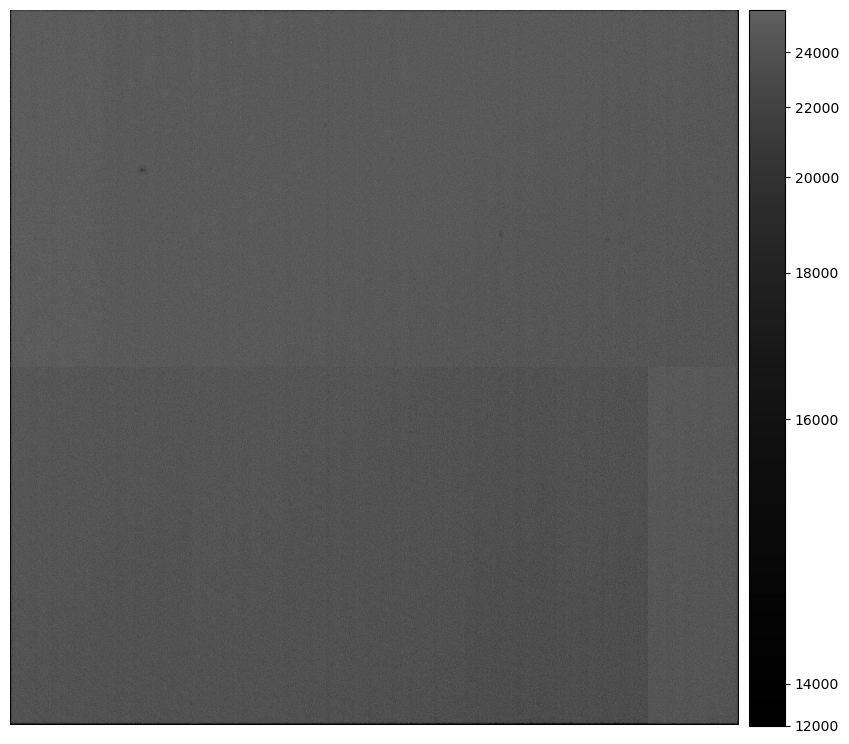

In [7]:
display(sflat)

In [8]:
from scipy.ndimage import gaussian_filter

In [9]:
ptc = butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/lsstccs/ptc_13511_w_2023_41')

In [15]:
arr = gaussian_filter(sflat.image.array, sigma=2)

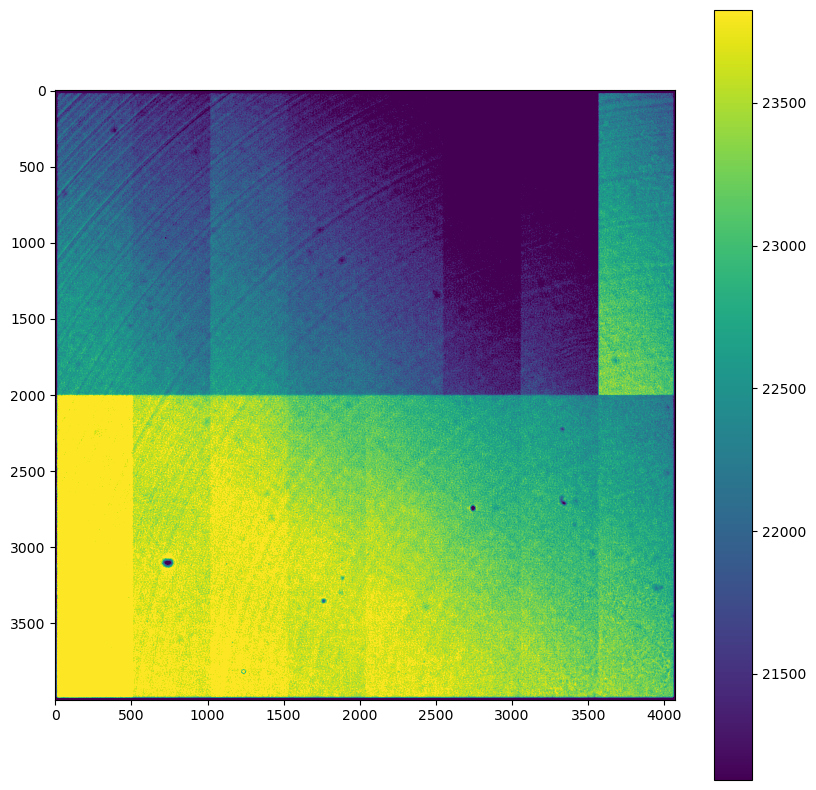

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(arr, vmin=22476.809-.06*22476.809, vmax=22476.809+.06*22476.809)
plt.colorbar()

In [45]:
def applyGain(exposure):
    exp = exposure.copy()
    image = exp.getMaskedImage().getImage()
    ccd = exp.getDetector()
    for amp in ccd:
        sim = image.Factory(image, amp.getBBox())
        gain = ptc.gain[amp.getName()]
        sim *= gain
    return exp

In [49]:
help(sflat)

Help on ExposureF in module lsst.afw.image._exposure object:

class ExposureF(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ExposureF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __deepcopy__(self, memo=None)
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.afw.image

In [46]:
exposure = applyGain(sflat)

AttributeError: 'lsst.afw.image._exposure._exposure.ExposureF' object has no attribute 'copy'

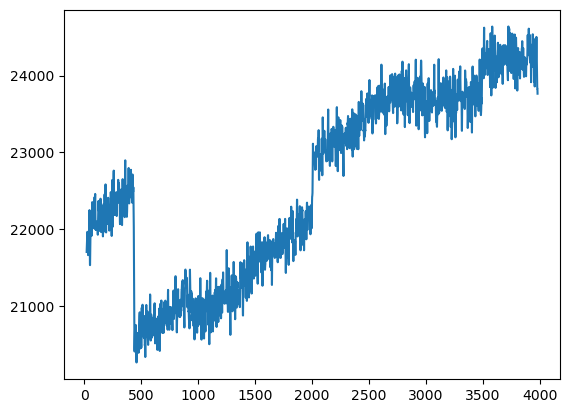

In [44]:
x = []
y = []
for i,j in zip(np.flip(np.arange(0,4000)),
               np.arange(0,4000)):
    x.append(i)
    y.append(arr[i,j])

plt.plot(x[20:-20],y[20:-20])

In [11]:
print(raw.getMetadata()['ef_43~HIGH)

KeyError: 'ef_43~HIGH not found'

In [6]:

# Get the calibrations
bias = butler.get('bias', detector=det_num, instrument="LSSTCam", collections='u/abrought/sbias.2023.11.08')
dark = butler.get('dark', detector=det_num, instrument="LSSTCam", collections='u/abrought/sdark.2023.11.08')
defects = butler.get('defect', detector=det_num, instrument="LSSTCam", collections='LSSTCam/calib')
camera = LsstCam().getCamera()


LookupError: Dataset bias with data ID {instrument: 'LSSTCam', detector: 23} could not be found in collections LSSTCam/calib.

In [ ]:

# Construct the task configuration
config = IsrTask.ConfigClass()
config.doDark = True
config.doBias = True
config.doOverscan = True
config.doFlat = False
config.doDefect = True
config.doLinearize=False
config.doBrighterFatter=False
config.doApplyGains=False

isrtask = IsrTask(config=config)


# Let's just run clean up 1 flat image. If you find that this image is noisy,
# we can clean up all the images and then run a different task to combine 
# them into a superflat.

flat = isrtask.run(raw_images[0], camera=camera, bias=bias,
                   dark=dark, defects=defects, detectorNum=det_num)
